In [1]:
import torch
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt 
from torchvision import datasets, transforms, models
from tqdm import tqdm
print(tf.__version__)

2.4.0


#### Constants

In [2]:
BATCH_SIZE = 32
CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

#### Dataset Loading from Keras

In [3]:
from keras.datasets import cifar10
(xTr, yTr), (xTe, yTe) = keras.datasets.cifar10.load_data()

# consider 1 training batch as validation
xVal, yVal = xTr[:10000], yTr[:10000]
# consider 4 training batches
xTr, yTr = xTr[10000:], yTr[10000:]



#### Visualize DataSet Shape

In [4]:
print(f"Training Matrix Shape for data: {xTr.shape}")
print(f"Training Matrix Shape for labels: {yTr.shape}")
print(f"Validation Matrix Shape for data: {xVal.shape}")
print(f"Validation Matrix Shape for labels: {yVal.shape}")
print(f"Testing Matrix Shape for data: {xTe.shape}")
print(f"Testing Matrix Shape for labels: {yTe.shape}")

Training Matrix Shape for data: (40000, 32, 32, 3)
Training Matrix Shape for labels: (40000, 1)
Validation Matrix Shape for data: (10000, 32, 32, 3)
Validation Matrix Shape for labels: (10000, 1)
Testing Matrix Shape for data: (10000, 32, 32, 3)
Testing Matrix Shape for labels: (10000, 1)


# (B) Classify the images in the CIFAR10 dataset

#### Model Definition

In [5]:
model = models.alexnet(pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

#### Preprocess

In [6]:
from PIL import Image
def preprocess(image):
    pil = Image.fromarray(image)  
    # change dimension to 224x224, convert to tensor, and normalize
    transform = transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(224), 
        transforms.ToTensor(), 
        transforms.Normalize( 
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
        )
    ])
    img = transform(pil) 
    # add dimension
    return torch.unsqueeze(img, 0).cuda() if torch.cuda.is_available() else torch.unsqueeze(img, 0)

#### Classify Images

In [7]:
with open('imagenet_classes.txt') as f: #read the categories from file
    classes = [line.strip() for line in f.readlines()]

# get top prediction
def predict(out):
    indices = torch.argsort(out, dim=1, descending=True)
    prob = torch.nn.functional.softmax(out, dim=1)[0] * 100
    return classes[indices[0][0]], prob[indices[0][0]].item()
    
occurences = {}
classified = []
for i in tqdm(range(xTe.shape[0])):
    current = preprocess(xTe[i])
    pred = model(current)
    imgClass, prob = predict(pred)
    if imgClass in occurences:
        occurences[imgClass] += 1 
    else:
        occurences[imgClass] = 1
    classified.append(imgClass)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:47<00:00, 212.07it/s]


#### Find Top 10

In [8]:
from collections import Counter
top10 = dict(Counter(occurences).most_common(10))
top10

{'moving van': 1253,
 'fox squirrel, eastern fox squirrel, Sciurus niger': 666,
 'sorrel': 398,
 'container ship, containership, container vessel': 344,
 'English foxhound': 301,
 'Dandie Dinmont, Dandie Dinmont terrier': 257,
 'thresher, thrasher, threshing machine': 249,
 'Japanese spaniel': 245,
 'milk can': 221,
 'chain saw, chainsaw': 164}


#### Check Test Set Distribution

In [9]:
distr = {}
# count class occurences
for x in top10.keys():
    distr[x] = [0 for i in range(len(CLASS_NAMES))]

# find distributions 
for i in range(len(classified)):
    if classified[i] in distr:
        distr[classified[i]][CLASS_NAMES.index(CLASS_NAMES[yTe[i][0]])] += 1

# visualize
for x in distr.items():
    print(x)

('moving van', [54, 433, 1, 8, 0, 0, 0, 13, 102, 642])
('fox squirrel, eastern fox squirrel, Sciurus niger', [6, 5, 134, 115, 136, 30, 213, 18, 6, 3])
('sorrel', [2, 0, 7, 5, 87, 4, 2, 288, 2, 1])
('container ship, containership, container vessel', [32, 6, 0, 0, 2, 0, 0, 2, 284, 18])
('English foxhound', [2, 3, 12, 48, 41, 97, 5, 91, 1, 1])
('Dandie Dinmont, Dandie Dinmont terrier', [1, 2, 9, 40, 20, 160, 14, 10, 0, 1])
('thresher, thrasher, threshing machine', [49, 52, 4, 0, 6, 0, 1, 12, 5, 120])
('Japanese spaniel', [2, 1, 10, 55, 5, 125, 3, 43, 1, 0])
('milk can', [10, 34, 18, 46, 13, 10, 14, 18, 36, 22])
('chain saw, chainsaw', [26, 83, 5, 4, 0, 1, 1, 3, 2, 39])


#### Make Confusion Matrix

<AxesSubplot:title={'center':'Confusion Matrix'}>

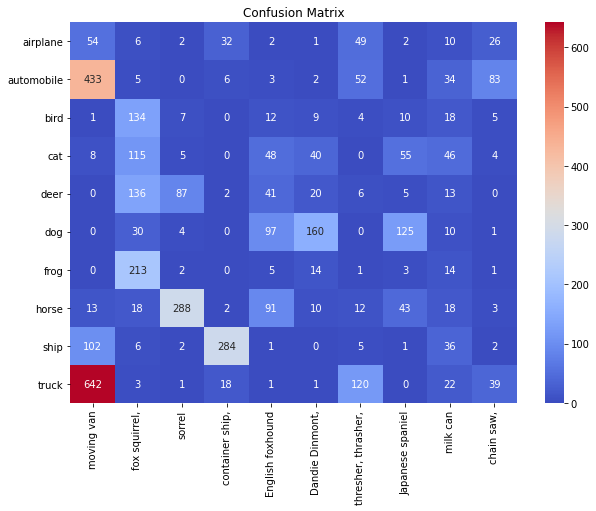

In [10]:
from seaborn import heatmap
import pandas as pd

# create 2D array from top10 distributions
arr = np.asarray([i for i in distr.values()]).T

# Plot 
df_cm = pd.DataFrame(arr, index = CLASS_NAMES, columns = [" ".join(i.split(" ")[:2]) for i in top10.keys()])
plt.figure(figsize = (10,7))
plt.title("Confusion Matrix")
heatmap(df_cm, annot = True, fmt = "d", cmap='coolwarm')

# (C) Extract features for all the images in the CIFAR10 dataset

#### Define Functions

In [11]:
def normalize_data(x_train, y_train, flat=True):
    x_train = x_train.astype(np.float32)
    x_train = torch.from_numpy(x_train)
    if flat:
        x_train = torch.flatten(x_train, 1)
    y_train = y_train.astype(np.int64)
    return x_train, torch.from_numpy(y_train).view(-1)

def train( model, train_loader, optimizer):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
    return loss.item(), correct / len(train_loader.dataset)

def test( model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += loss_fn(output, target).item() 
            pred = output.argmax(dim=1, keepdim=True)  
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    return test_loss,  correct / len(test_loader.dataset)

#### Build fc6 Model

In [12]:
# Get Classifiers
model6 = models.alexnet(pretrained=True)
fc6 = torch.nn.Sequential(*list(model6.classifier.children())[:2])
# change model
model6.classifier = fc6
# send to GPU
model6.cuda()
model6.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

#### Extract Features from Entire Dataset

In [13]:
fullSetX = np.concatenate((xVal, xTr, xTe))
# fullSetY = np.concatenate((yVal, yTr, yTe))
features = []
for i in tqdm(range(fullSetX.shape[0])):
    current = preprocess(fullSetX[i])
    pred = model6(current).reshape(4096).cpu().detach().numpy()
    features.append(pred)
len(features)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [03:52<00:00, 258.45it/s]


60000

#### Define Linear Classifier

In [14]:
import torch.nn.functional as F
class Linear(torch.nn.Module):
    def __init__(self, input_size, number_of_classes=10):
        super(Linear, self).__init__()
        self.lin1 = torch.nn.Linear(input_size,64)
        self.lin2 = torch.nn.Linear(64,number_of_classes)

    def forward(self, x):
        x = F.relu(self.lin1(x))
        return self.lin2(x)

#### Dataset Loading 

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

# Split the full set of features
fc6Val = np.array(features[:10000])
fc6Tr = np.array(features[10000:50000])
fc6Te = np.array(features[50000:])

fc6Tr_norm, yTr_norm = normalize_data(fc6Tr, yTr)
loaderTr = torch.utils.data.TensorDataset(fc6Tr_norm, yTr_norm)
loaderTr = torch.utils.data.DataLoader(loaderTr, BATCH_SIZE)

fc6Val_norm, yVal_norm = normalize_data(fc6Val, yVal)
loaderVal = torch.utils.data.TensorDataset(fc6Val_norm, yVal_norm)
loaderVal = torch.utils.data.DataLoader(loaderVal, BATCH_SIZE)

fc6Te_norm, yTe_norm = normalize_data(fc6Te, yTe)
loaderTe = torch.utils.data.TensorDataset(fc6Te_norm, yTe_norm)
loaderTe = torch.utils.data.DataLoader(loaderTe, BATCH_SIZE)

linReg = Linear(fc6Tr[0].shape[0])
linReg.cuda()


Linear(
  (lin1): Linear(in_features=4096, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=10, bias=True)
)

#### Running the Training

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:58<00:00,  2.37s/it]


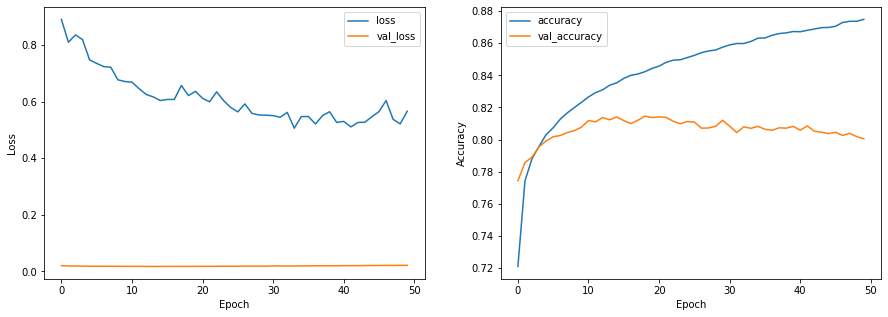

In [16]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(linReg.parameters())
EPOCHS = 50
loss_history = []
acc_history = []
for i in tqdm(range(EPOCHS)):
    train_loss, train_acc = train(linReg, loaderTr, optimizer)
    val_loss, val_acc = test(linReg, loaderVal)
    loss_history.append((train_loss, val_loss))
    acc_history.append((train_acc, val_acc))
    
fig, axs = plt.subplots(1,2,figsize=(15,5))
loss_history = np.array(loss_history)
acc_history = np.array(acc_history)
epochs_range = range(len(loss_history))

axs[0].plot(epochs_range, loss_history[:, 0])
axs[0].plot(epochs_range, loss_history[:, 1])
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend(['loss', 'val_loss'])

axs[1].plot(epochs_range, acc_history[:, 0])
axs[1].plot(epochs_range, acc_history[:, 1])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['accuracy', 'val_accuracy'])


In [17]:
loss, acc = test(linReg, loaderTe)
print(f"Test Dataset Loss: {loss}, Accuracy: {acc}")

Test Dataset Loss: 0.02272411562651396, Accuracy: 0.7926


# (D) Extract features for all the images in the CIFAR10 dataset

#### Build fc7 Model

In [18]:
# Get Classifiers
model7 = models.alexnet(pretrained=True)
fc7 = torch.nn.Sequential(*list(model7.classifier.children())[:5])
# change model
model7.classifier = fc7
# send to GPU
model7.cuda()
model7.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

#### Extract Features from Entire Dataset

In [19]:
fullSetX = np.concatenate((xVal, xTr, xTe))
# fullSetY = np.concatenate((yVal, yTr, yTe))
features = []
for i in tqdm(range(fullSetX.shape[0])):
    current = preprocess(fullSetX[i])
    pred = model7(current).reshape(4096).cpu().detach().numpy()
    features.append(pred)
len(features)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [04:53<00:00, 204.45it/s]


60000

#### Dataset Loading

In [20]:
# Split the full set of features
fc7Val = np.array(features[:10000])
fc7Tr = np.array(features[10000:50000])
fc7Te = np.array(features[50000:])

fc7Tr_norm, yTr_norm = normalize_data(fc7Tr, yTr)
loaderTr = torch.utils.data.TensorDataset(fc7Tr_norm, yTr_norm)
loaderTr = torch.utils.data.DataLoader(loaderTr, BATCH_SIZE)

fc7Val_norm, yVal_norm = normalize_data(fc7Val, yVal)
loaderVal = torch.utils.data.TensorDataset(fc7Val_norm, yVal_norm)
loaderVal = torch.utils.data.DataLoader(loaderVal, BATCH_SIZE)

fc7Te_norm, yTe_norm = normalize_data(fc7Te, yTe)
loaderTe = torch.utils.data.TensorDataset(fc7Te_norm, yTe_norm)
loaderTe = torch.utils.data.DataLoader(loaderTe, BATCH_SIZE)

linReg = Linear(fc7Tr[0].shape[0])
linReg.cuda()


Linear(
  (lin1): Linear(in_features=4096, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=10, bias=True)
)

#### Running the Training

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:06<00:00,  2.54s/it]


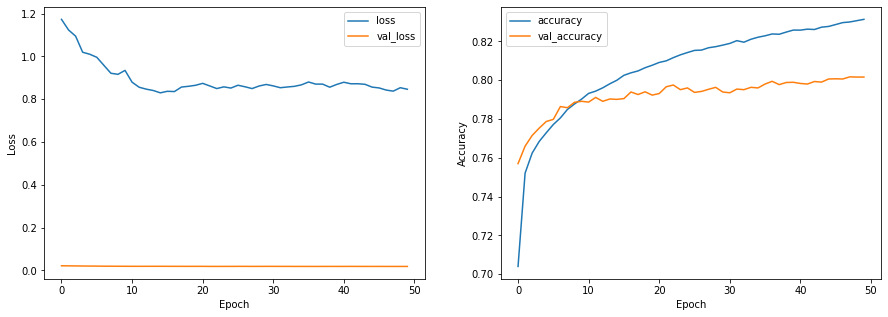

In [21]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(linReg.parameters())
loss_history = []
acc_history = []
for i in tqdm(range(EPOCHS)):
    train_loss, train_acc = train(linReg, loaderTr, optimizer)
    val_loss, val_acc = test(linReg, loaderVal)
    loss_history.append((train_loss, val_loss))
    acc_history.append((train_acc, val_acc))
    
fig, axs = plt.subplots(1,2,figsize=(15,5))
loss_history = np.array(loss_history)
acc_history = np.array(acc_history)
epochs_range = range(len(loss_history))

axs[0].plot(epochs_range, loss_history[:, 0])
axs[0].plot(epochs_range, loss_history[:, 1])
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend(['loss', 'val_loss'])

axs[1].plot(epochs_range, acc_history[:, 0])
axs[1].plot(epochs_range, acc_history[:, 1])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['accuracy', 'val_accuracy'])


In [22]:
loss, acc = test(linReg, loaderTe)
print(f"Test Dataset Loss: {loss}, Accuracy: {acc}")

Test Dataset Loss: 0.01829167063832283, Accuracy: 0.7978
